**Analyzing and Comparing Supervised Methods on Hyperspectral Images**

*by Zarnescu Dragos-Ioan 331 AB*



## Teoretical Introduction for Hyperspectral Imaging

- What are Hyperspectral Images and where it can be applied ?
    - It captures the images through a larger scale of wavelenghts of light that are more detalied than the conventional image that are captured rahter through RGB channels
    - Each pixel in a hyperspectral image represents a spectrum of light reflected or emitted from the surface, covering a wide range of wavelengths
    - Instead of just having three channels (red, green, blue), as in RGB images, hyperspectral images have hundreds of channels (spectral bands) that provide detailed information about the composition of materials.

    - Its applicability consists in obtaining precise information about the image described, usually if we talk about celestic objects or materials of an object, such as chemical and physical properties of a given object 
    - Domains where it is usually applied
        - Precision Agriculture: used to monitor plant health, detect vegetation stress, assess soil conditions, and estimate crop yield. The spectrum reflected by plants can provide information about water levels, nutrients, etc
        - In archaeology, hyperspectral technology can help discover and map archaeological sites, detecting hidden land features or underground structures that are not visible to the naked eye.
        - In medicine, hyperspectral imaging can assist in diagnosing skin diseases, such as cancer or other conditions, by analyzing subtle differences in the spectra reflected by tissue

    
   

 # Example of a hyperspectral image

   - In the following example, i took a sample from https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes of the Salina Valley in California that was taken through an Aviris Sensor. The area covered comprises 512 lines by 217 samples.  This image was available only as at-sensor radiance data. It includes vegetables, bare soils, and vineyard fields. Salinas groundtruth contains 16 classes.
    
   - Also for this image, there were 20 discarded bands that were related to water absorbtion features that were irrelevant for the analysis of soil and vegetation

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
Shape of the hyperspectral image: (512, 217, 204)
Shape of the ground truth image: (512, 217)


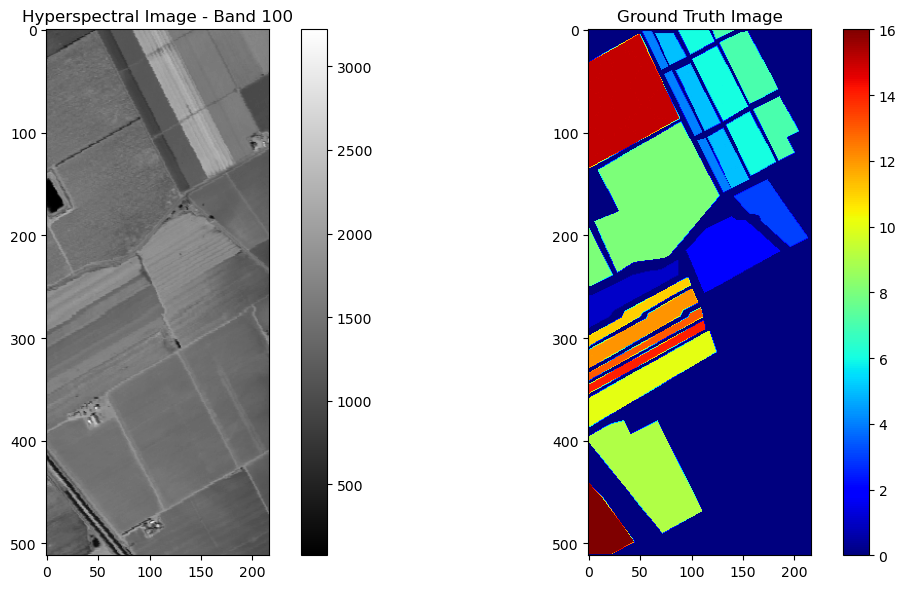

In [117]:
import scipy.io
import warnings
from sklearn.exceptions import ConvergenceWarning

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.transform import resize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
warnings.simplefilter("ignore", ConvergenceWarning)


hyper_image = scipy.io.loadmat('Salinas_corrected.mat')
print(hyper_image.keys())
hyper_image = hyper_image['salinas_corrected']

hyper_image_gt = scipy.io.loadmat('Salinas_gt.mat')
hyper_image_gt = hyper_image_gt['salinas_gt']
print ("Shape of the hyperspectral image:", hyper_image.shape)

print("Shape of the ground truth image:", hyper_image_gt.shape)

# Show the hyperspectral image (choose one band for visualization)
band_number = 99
band_image = hyper_image[:, :, band_number] 

#Plot the selected band from the hyperspectral image
plt.figure(figsize=(12, 6))

# Display the hyperspectral image band
plt.subplot(1, 2, 1)
plt.imshow(band_image, cmap='gray')
plt.title(f'Hyperspectral Image - Band {band_number + 1}')
plt.colorbar()

# Display the ground truth image
plt.subplot(1, 2, 2)
plt.imshow(hyper_image_gt, cmap='jet')
plt.title('Ground Truth Image')
plt.colorbar()

plt.tight_layout()
plt.show()


 # Prepocessing and visualize the data using this methods

  - Composite RGB Image: chosing 3 random bands and stack to form an RGB image

  - PCA, it reduces the hyperspectral image dimensions to three components.
    - The reshaping prepares the data for PCA.
    - The PCA-transformed image is reshaped back to spatial dimensions and normalized.

  - ICA is a statistical technique used to separate a multivariate signal into additive, independent components. 
    - It assumes that the observed data is a mixture of non-Gaussian sources and aims to recover these sources.
    - Unlike PCA, which maximizes variance, ICA aims to find components that are statistically independent from each other

  - OCP projects the data onto a subspace orthogonal to a certain reference, such as a signal or background, while retaining the key features for classification.
    - It identifies a subspace where relevant information is emphasized, and irrelevant information (background or noise) is minimized by projecting onto the orthogonal complement of the signal subspace.

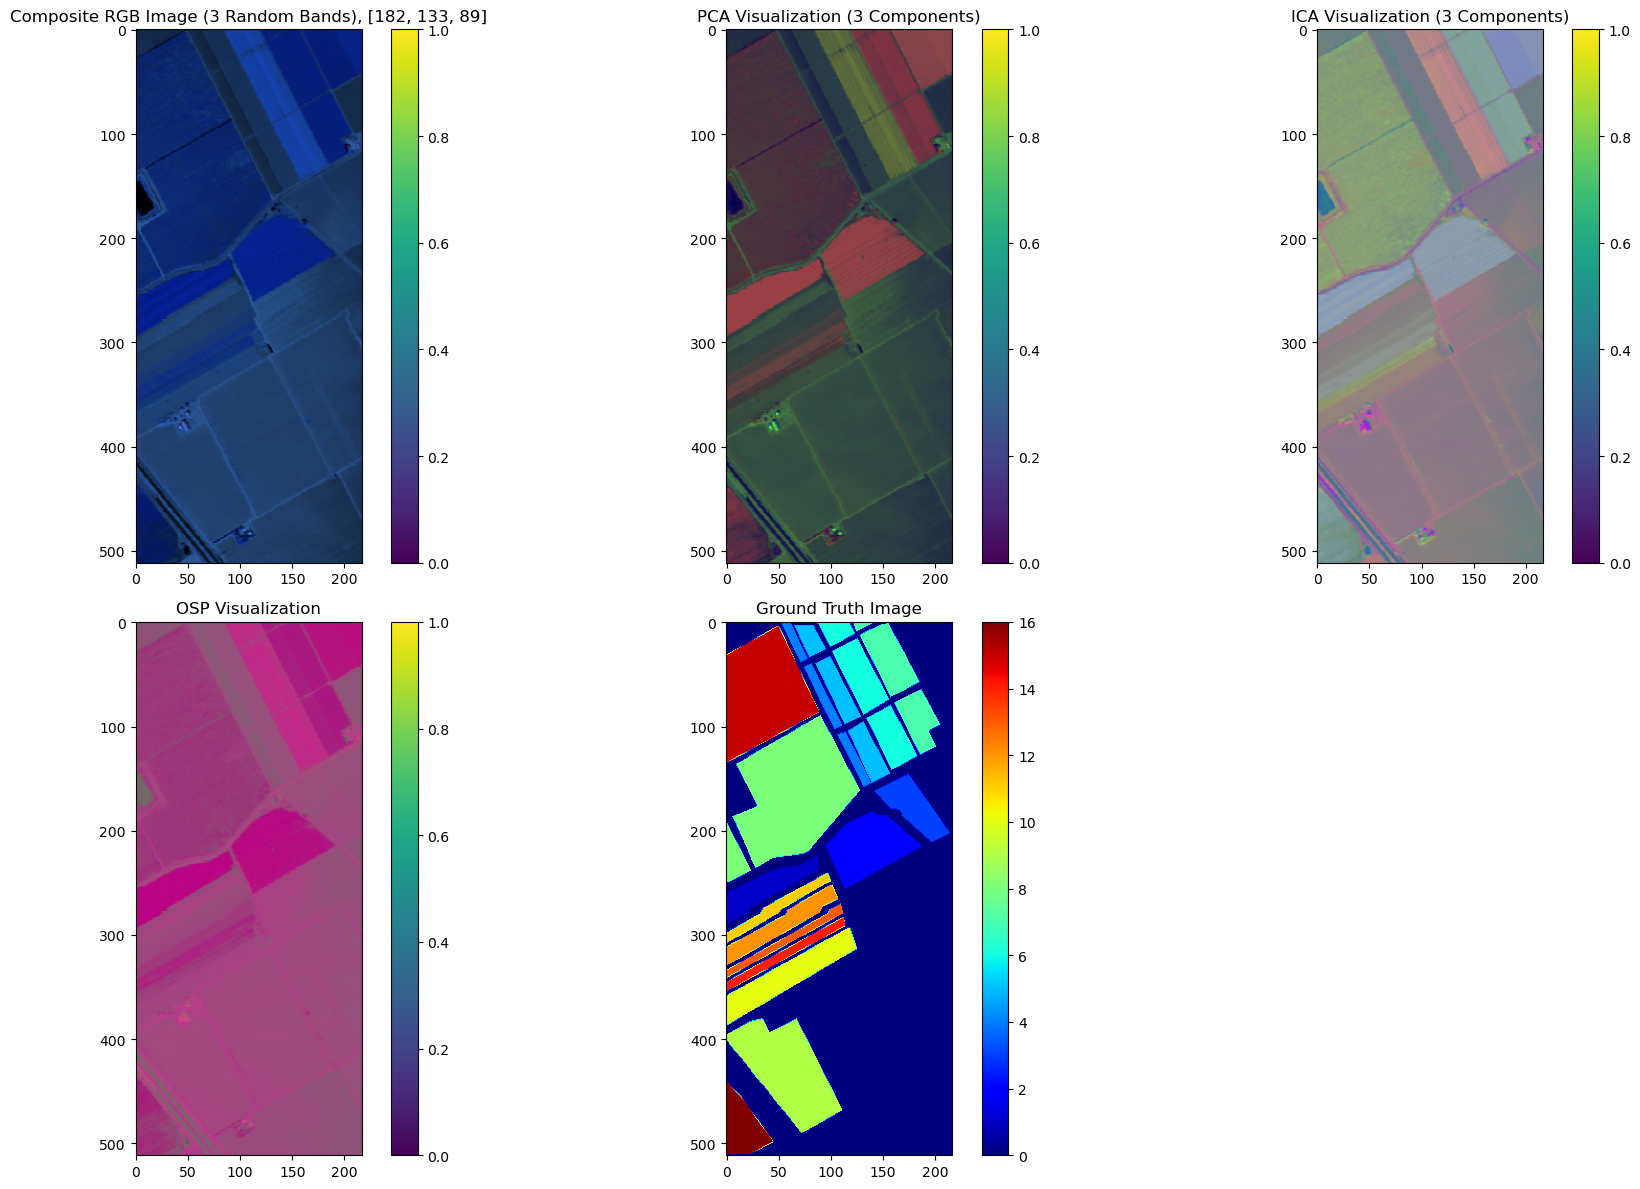

In [109]:

# three random bands to create a composite RGB image

band_1 = np.random.randint(0, hyper_image.shape[2])
band_2 = np.random.randint(0, hyper_image.shape[2])
band_3 = np.random.randint(0, hyper_image.shape[2])
rgb_image = np.stack((
    hyper_image[:, :, band_1], 
    hyper_image[:, :, band_2], 
    hyper_image[:, :, band_3]
), axis=-1)

# Normalize the RGB image for display purposes
rgb_image_normalized = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Apply PCA
def apply_pca(hyper_image, n_components):
    flattened_image = hyper_image.reshape(-1, hyper_image.shape[2])
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(flattened_image)
    pca_image = pca_result.reshape(hyper_image.shape[0], hyper_image.shape[1], n_components)
    return pca_image

# Apply ICA
def apply_ica(hyper_image, n_components):
    flattened_image = hyper_image.reshape(-1, hyper_image.shape[2])
    ica = FastICA(n_components=n_components)
    ica_result = ica.fit_transform(flattened_image)
    ica_image = ica_result.reshape(hyper_image.shape[0], hyper_image.shape[1], n_components)
    return ica_image

# Apply OSP (Orthogonal Subspace Projection)
def apply_osp(hyper_image, subspace_matrix):
    flattened_image = hyper_image.reshape(-1, hyper_image.shape[2])
    osp_result = np.dot(flattened_image, subspace_matrix.T)
    osp_image = osp_result.reshape(hyper_image.shape[0], hyper_image.shape[1], subspace_matrix.shape[0])
    return osp_image

# Example: Apply all methods
n_components = 3  # Number of components for PCA, NMF, ICA, OSP

# PCA result
pca_image = apply_pca(hyper_image, n_components)
pca_image_normalized = (pca_image - pca_image.min()) / (pca_image.max() - pca_image.min())


# ICA result
ica_image = apply_ica(hyper_image, n_components)
ica_image_normalized = (ica_image - ica_image.min()) / (ica_image.max() - ica_image.min())

# OSP result (using a random subspace matrix for demonstration, replace with actual subspace)
subspace_matrix = np.random.randn(3, hyper_image.shape[2])  # Random 3x bands subspace for illustration
osp_image = apply_osp(hyper_image, subspace_matrix)
osp_image_normalized = (osp_image - osp_image.min()) / (osp_image.max() - osp_image.min())

# Plot all results together
plt.figure(figsize=(18, 12))

# Display RGB Image
plt.subplot(2, 3, 1)
plt.imshow(rgb_image_normalized)
plt.title('Composite RGB Image (3 Random Bands), {}'.format([band_1, band_2, band_3]))
plt.colorbar()

# Display PCA Image
plt.subplot(2, 3, 2)
plt.imshow(pca_image_normalized)
plt.title(f'PCA Visualization ({n_components} Components)')
plt.colorbar()

# Display ICA Image
plt.subplot(2, 3, 3)
plt.imshow(ica_image_normalized)
plt.title(f'ICA Visualization ({n_components} Components)')
plt.colorbar()

# Display OSP Image
plt.subplot(2, 3, 4)
plt.imshow(osp_image_normalized)
plt.title(f'OSP Visualization')
plt.colorbar()

# Display Ground Truth Image
plt.subplot(2, 3, 5)
plt.imshow(hyper_image_gt, cmap='jet')
plt.title('Ground Truth Image')
plt.colorbar()

plt.tight_layout()
plt.show()


# Preproccesing data

- Understanding the data that we have for classification we see that we have 1 - 16 labels for different products of the valley and 0 that stands for the background ( white color ) in the groundtruth image

- First step of preproccesing consists in flattening the images of the hyperspectral and the groundtruth to get X our dataset as a 2D image consisting in (height * width,bands) and y the labels of the data that we take the classification of.
- To get a better approximation we filter the data where the label is not 0 , also when reconstructing the images when we predict through our classifier we take it in connsideration

- To ensure all features have equal influence, we scale the data through StandardScaler
- I chose PCA to reduce our data as it will be faster for training, as we reduce the data to only the components with the most variance

- Also in this step i calculate the weight of the classes to ensure that when i perform classification, the model doesn't favor the dominant class
 

In [102]:
# Prepocessing data for classification

# Reshape hyperspectral image to 2D: (height * width, bands)
X = hyper_image.reshape(-1, hyper_image.shape[2])

# Flatten the ground truth image into 1D (height * width,)
y = hyper_image_gt.flatten()


# Create a mask for non-background pixels
mask = hyper_image_gt.flatten() != 0

# Filter out background pixels
X_valid = X[mask]  # Select only valid pixels (non-background)
y_valid = y[mask]  # Corresponding labels


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

# Reduce the number of components 
pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_valid = pca.transform(X_valid)


# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights_dict = {i: weight for i, weight in zip(np.unique(y), class_weights)}




# Teoretical Introduction for Classification methods

- For this project, as we have the labels from the groundtrough photo, we perform supervised classification where a model can predict the labels for new observations

- Comparing the methods we are gonna use :
 
    - __SVM__ aims to draw a hyperplane for the classificaton task. It separates the classes by maximizing the margin between the nearest points of two classes. It solves the Convex Optimization Problem where we want to maximize the margin having the constraints that each point should be in its cluster

    - __Random forest__ is an ensemble method that builds multiple decision trees during training and combines their predictions. Each tree is trained on a random subset of the data and features (bagging), which reduces overfitting.

    - __Logistic Regression__ is a linear model that estimates probabilities using the logistic sigmoid function. The model fits a linear decision boundary by finding the weights that maximize the likelihood of the observed data.


   ### From the teoretical pov we can find advantages and disadvantages such as
- __SVM__ is effective for high-dimensional data, handles non-linear problems (with kernels), but also is	computationally intensive and sensitive to hyperparameters
- __Random Forest__	handles non-linear relationships, is robust to overfitting and also interpretable, but also is Computationally expensive, harder to interpret individual trees
- __Logistic Regression__	is simple, interpretable, outputs probabilities, but limited to linear boundaries and sensitive to outliers
    

In [110]:
# function for evaluating performance of a classifier
class_labels = {
    1: "Brocoli_green_weeds_1", 
    2: "Brocoli_green_weeds_2", 
    3: "Fallow", 
    4: "Fallow_rough_plow", 
    5: "Fallow_smooth", 
    6: "Stubble", 
    7: "Celery", 
    8: "Grapes_untrained", 
    9: "Soil_vinyard_develop", 
    10: "Corn_senesced_green_weeds", 
    11: "Lettuce_romaine_4wk", 
    12: "Lettuce_romaine_5wk", 
    13: "Lettuce_romaine_6wk", 
    14: "Lettuce_romaine_7wk", 
    15: "Vinyard_untrained", 
    16: "Vinyard_vertical_trellis"
}
def evaluate_metrics(y_true, y_pred,is_print = True):
    # Calcularea metricilor
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Matricea de confuzie
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Afisarea valorilor
    if(is_print):
        print(f"Acuratețea: {accuracy * 100:.2f}%")
        print(f"Precizia: {precision * 100:.2f}%")
        print(f"Sensibilitatea: {recall * 100:.2f}%")
        print(f"F1-Score: {f1 * 100:.2f}%")

        # Afișarea matricei de confuzie
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
        plt.title('Matricea de Confuzie')
        plt.xlabel('Clasă Predicted')
        plt.ylabel('Clasă Reală')
        plt.show()

        #Raportul detaliat al clasificării (precizie, recall, F1-score)
        print("\nRaportul de clasificare:")
        print(classification_report(y_true, y_pred, target_names=class_labels.values()))
    else: 
        return accuracy, precision, recall, f1


In [113]:
def evaluate_classifier(clf, X_train, y_train, X_test, y_test, is_reconstructed=True):
    # Antrenarea clasificatorului
    clf.fit(X_train, y_train)

    # Prezicerea claselor pentru setul de testare
    y_pred = clf.predict(X_test)

    if(is_reconstructed):
        evaluate_metrics(y_test, y_pred)
        full_image_predictions= clf.predict(X_valid)
        
        # Reconstruct the full image to its original shape
        print("Shape of full_image_predictions:", full_image_predictions.shape)
        print("Number of valid pixels (mask sum):", np.sum(mask))

        # Reconstruct the full image
        full_image = np.zeros_like(hyper_image_gt, dtype=int)  # Initialize with zeros (background)
        full_image[mask.reshape(hyper_image_gt.shape)] = full_image_predictions  # Map predictions back to the 2D image
        return full_image, accuracy_score(y_test, y_pred)
    else :
        return evaluate_metrics(y_test, y_pred,is_print=False)


# Evaluation Metrics

- As we ran the models we should evaluate it by some standards to know how it performs 
    - Accuracy is defined as the proportion of correctly predicted instances, used to get an overall sense of how well the model is performing
    
    - Precision measures the proportion of positive predictions that are actually correct.
    
    - Senitivity measures the proportion of actual positives that were correctly identified by the model.
    
    - F1-score is the harmonic mean of precision and recall. It combines both metrics into a single value, balancing the trade-off between precision and recall. It 
    provides a balanced view of the model’s performance, particularly when false positives and false negatives are equally costly.
    
    - Confusion matrix is a table used to evaluate the performance of a classification model. It compares the predicted labels with the true labels, providing counts of true positives, true negatives, false positives, and false negatives.


Acuratețea: 93.66%
Precizia: 94.04%
Sensibilitatea: 93.66%
F1-Score: 93.45%


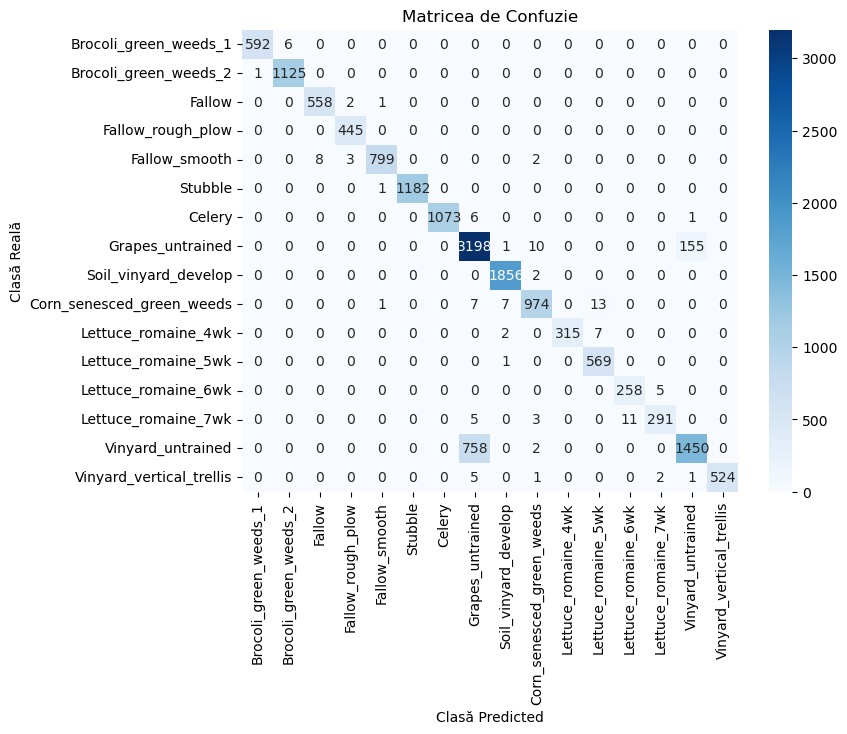


Raportul de clasificare:
                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       1.00      0.99      0.99       598
    Brocoli_green_weeds_2       0.99      1.00      1.00      1126
                   Fallow       0.99      0.99      0.99       561
        Fallow_rough_plow       0.99      1.00      0.99       445
            Fallow_smooth       1.00      0.98      0.99       812
                  Stubble       1.00      1.00      1.00      1183
                   Celery       1.00      0.99      1.00      1080
         Grapes_untrained       0.80      0.95      0.87      3364
     Soil_vinyard_develop       0.99      1.00      1.00      1858
Corn_senesced_green_weeds       0.98      0.97      0.98      1002
      Lettuce_romaine_4wk       1.00      0.97      0.99       324
      Lettuce_romaine_5wk       0.97      1.00      0.98       570
      Lettuce_romaine_6wk       0.96      0.98      0.97       263
      Lettuce_romaine_7wk       0.9

In [105]:
# Use Random Forest for classification
rf = RandomForestClassifier(class_weight= class_weights_dict,n_estimators=100, random_state=42)
full_image_rf, rf_accuracy = evaluate_classifier(rf, X_train, y_train, X_test, y_test)


Acuratețea: 92.17%
Precizia: 92.12%
Sensibilitatea: 92.17%
F1-Score: 92.14%


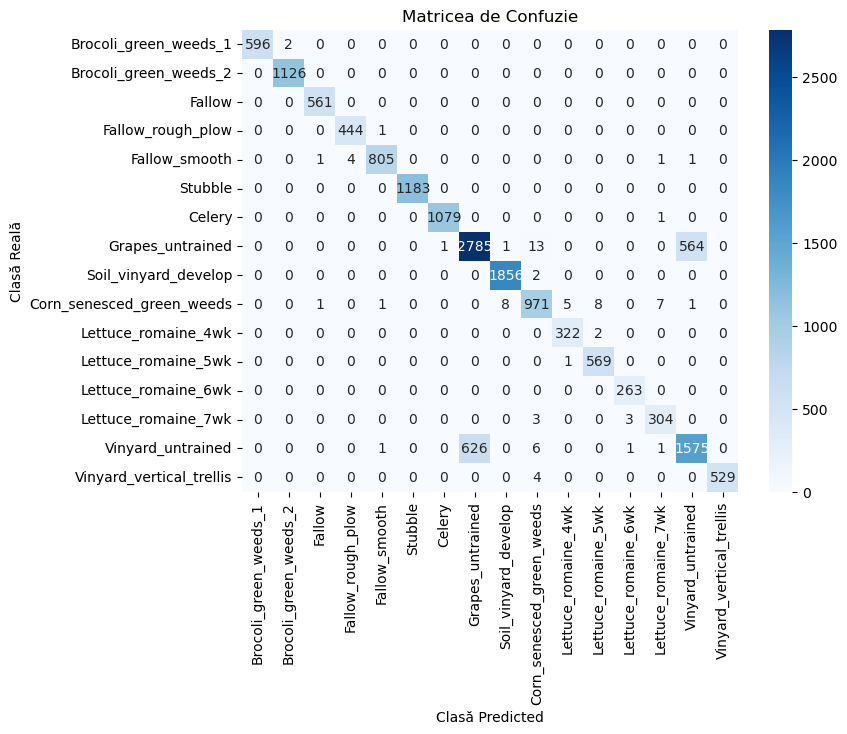


Raportul de clasificare:
                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       1.00      1.00      1.00       598
    Brocoli_green_weeds_2       1.00      1.00      1.00      1126
                   Fallow       1.00      1.00      1.00       561
        Fallow_rough_plow       0.99      1.00      0.99       445
            Fallow_smooth       1.00      0.99      0.99       812
                  Stubble       1.00      1.00      1.00      1183
                   Celery       1.00      1.00      1.00      1080
         Grapes_untrained       0.82      0.83      0.82      3364
     Soil_vinyard_develop       1.00      1.00      1.00      1858
Corn_senesced_green_weeds       0.97      0.97      0.97      1002
      Lettuce_romaine_4wk       0.98      0.99      0.99       324
      Lettuce_romaine_5wk       0.98      1.00      0.99       570
      Lettuce_romaine_6wk       0.99      1.00      0.99       263
      Lettuce_romaine_7wk       0.9

In [106]:
# Use Logistic Regression for classification

lr = LogisticRegression(class_weight=class_weights_dict,max_iter=2000)
full_image_lr,logistic_accuracy = evaluate_classifier(lr, X_train, y_train, X_test, y_test)

Acuratețea: 91.74%
Precizia: 91.62%
Sensibilitatea: 91.74%
F1-Score: 91.59%


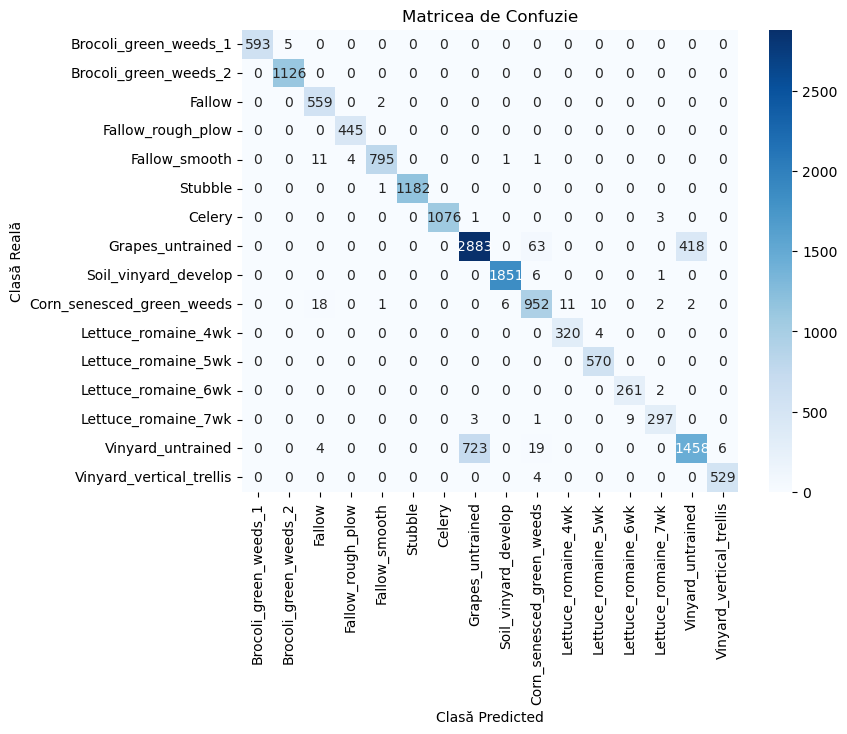


Raportul de clasificare:
                           precision    recall  f1-score   support

    Brocoli_green_weeds_1       1.00      0.99      1.00       598
    Brocoli_green_weeds_2       1.00      1.00      1.00      1126
                   Fallow       0.94      1.00      0.97       561
        Fallow_rough_plow       0.99      1.00      1.00       445
            Fallow_smooth       0.99      0.98      0.99       812
                  Stubble       1.00      1.00      1.00      1183
                   Celery       1.00      1.00      1.00      1080
         Grapes_untrained       0.80      0.86      0.83      3364
     Soil_vinyard_develop       1.00      1.00      1.00      1858
Corn_senesced_green_weeds       0.91      0.95      0.93      1002
      Lettuce_romaine_4wk       0.97      0.99      0.98       324
      Lettuce_romaine_5wk       0.98      1.00      0.99       570
      Lettuce_romaine_6wk       0.97      0.99      0.98       263
      Lettuce_romaine_7wk       0.9

In [107]:
# use svm for classification
svm = SVC(class_weight=class_weights_dict)
full_image_svm, svm_accuracy = evaluate_classifier(svm, X_train, y_train, X_test, y_test)

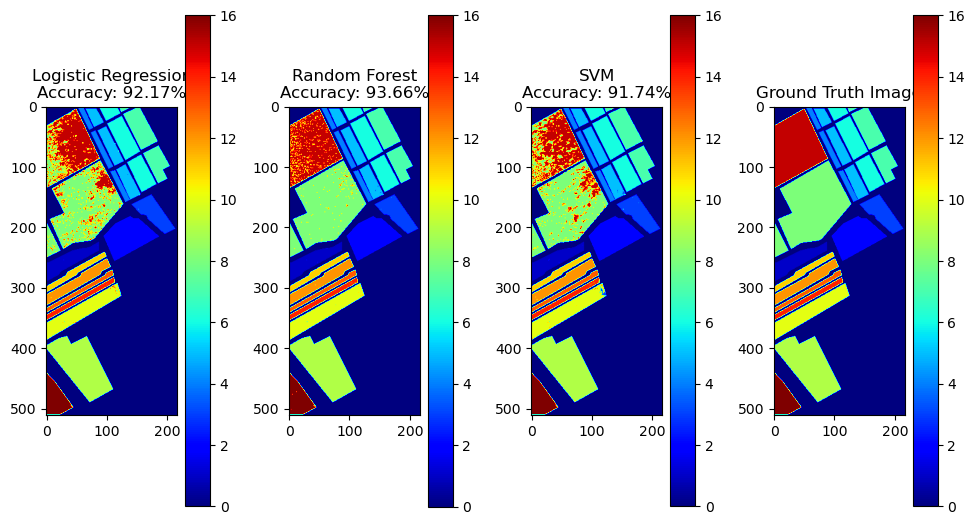

In [108]:
# Plot the classification results for each model
plt.figure(figsize=(12, 10))

# Logistic Regression Results
plt.subplot(1, 5, 1)
plt.imshow(full_image_lr, cmap='jet')
plt.title(f"Logistic Regression\nAccuracy: {logistic_accuracy * 100:.2f}%")
plt.colorbar()

# Random Forest Results
plt.subplot(1, 5, 2)
plt.imshow(full_image_rf, cmap='jet')
plt.title(f"Random Forest\nAccuracy: {rf_accuracy * 100:.2f}%")
plt.colorbar()

# SVM Results
plt.subplot(1, 5, 3)
plt.imshow(full_image_svm, cmap='jet')
plt.title(f"SVM\nAccuracy: {svm_accuracy * 100:.2f}%")
plt.colorbar()
plt.subplot(1, 5, 4)
plt.imshow(hyper_image_gt, cmap='jet')
plt.title('Ground Truth Image')
plt.colorbar()

plt.tight_layout()
plt.show()

In [119]:

components = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

scores_lr = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

scores_rf = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}

scores_svm = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': []
}
for i in range (0, len(components)):
    pca = PCA(n_components=components[i])
    mask = hyper_image_gt.flatten() != 0
    y = hyper_image_gt.flatten()
    X_valid = X[mask] 
    y_valid = y[mask]  
    X_train, X_test, y_train, y_test = train_test_split(X_valid, y_valid, test_size=0.3, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_valid_pca = pca.transform(X_valid)

    # Evaluate Logistic Regression and store results
    lr_accuracy, lr_precision, lr_recall, lr_f1 = evaluate_classifier(lr, X_train_pca, y_train, X_test_pca, y_test, is_reconstructed=False)
    scores_lr['accuracy'].append(lr_accuracy)
    scores_lr['precision'].append(lr_precision)
    scores_lr['recall'].append(lr_recall)
    scores_lr['f1'].append(lr_f1)

    # Evaluate Random Forest and store results
    rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_classifier(rf, X_train_pca, y_train, X_test_pca, y_test, is_reconstructed=False)
    scores_rf['accuracy'].append(rf_accuracy)
    scores_rf['precision'].append(rf_precision)
    scores_rf['recall'].append(rf_recall)
    scores_rf['f1'].append(rf_f1)

    # Evaluate SVM and store results
    svm_accuracy, svm_precision, svm_recall, svm_f1 = evaluate_classifier(svm, X_train_pca, y_train, X_test_pca, y_test, is_reconstructed=False)
    scores_svm['accuracy'].append(svm_accuracy)
    scores_svm['precision'].append(svm_precision)
    scores_svm['recall'].append(svm_recall)
    scores_svm['f1'].append(svm_f1)

    print(f"\n\nPCA with {components[i]} components done")


# After the loop, you will have a dictionary of scores for each classifier and each number of PCA components
print("Logistic Regression Scores:", scores_lr)
print("Random Forest Scores:", scores_rf)
print("SVM Scores:", scores_svm)

# Function to plot the metrics
def plot_metrics(components, scores_lr, scores_rf, scores_svm):
    # Create subplots for accuracy, precision, recall, and F1 score
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot Accuracy
    axes[0, 0].plot(components, scores_lr['accuracy'], label='Logistic Regression', marker='o')
    axes[0, 0].plot(components, scores_rf['accuracy'], label='Random Forest', marker='o')
    axes[0, 0].plot(components, scores_svm['accuracy'], label='SVM', marker='o')
    axes[0, 0].set_title('Accuracy')
    axes[0, 0].set_xlabel('Number of PCA Components')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()

    # Plot Precision
    axes[0, 1].plot(components, scores_lr['precision'], label='Logistic Regression', marker='o')
    axes[0, 1].plot(components, scores_rf['precision'], label='Random Forest', marker='o')
    axes[0, 1].plot(components, scores_svm['precision'], label='SVM', marker='o')
    axes[0, 1].set_title('Precision')
    axes[0, 1].set_xlabel('Number of PCA Components')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].legend()

    # Plot Recall
    axes[1, 0].plot(components, scores_lr['recall'], label='Logistic Regression', marker='o')
    axes[1, 0].plot(components, scores_rf['recall'], label='Random Forest', marker='o')
    axes[1, 0].plot(components, scores_svm['recall'], label='SVM', marker='o')
    axes[1, 0].set_title('Recall')
    axes[1, 0].set_xlabel('Number of PCA Components')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()

    # Plot F1 Score
    axes[1, 1].plot(components, scores_lr['f1'], label='Logistic Regression', marker='o')
    axes[1, 1].plot(components, scores_rf['f1'], label='Random Forest', marker='o')
    axes[1, 1].plot(components, scores_svm['f1'], label='SVM', marker='o')
    axes[1, 1].set_title('F1 Score')
    axes[1, 1].set_xlabel('Number of PCA Components')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
# plot_metrics(components, scores_lr, scores_rf, scores_svm)


TypeError: cannot unpack non-iterable float object

# Final Conclusion

1. Which Method performs better and why ?

- From the results, we can see that Random Forest outperformed both Logistic Regression and SVM in all metrics (Accuracy, Precision, Sensitivity, F1-Score)

- Random Forest is an ensemble method that aggregates predictions from multiple decision trees. This often results in better generalization and better handling of complex relationships in data, which is why it might perform better in a variety of tasks.

- Better Performance: The higher accuracy and precision  of Random Forest indicate that it was able to make more accurate and more confident predictions compared to the other models.

- Ensemble Learning Advantage: Random Forest leverages the idea of averaging multiple decision trees to avoid overfitting and improve robustness, which typically gives it an edge when dealing with complex, high-dimensional data, such as hyperspectral images.

- Logistic Regression and SVM achieved identical results, with accuracy, precision, recall, and F1-score all at 92.17%. These methods performed similarly, with Logistic Regression being a simpler linear model and SVM focusing on finding the optimal hyperplane for classification. Neither of these methods had the ensemble advantage that Random Forest benefits from.

- Simplicity vs. Complexity: Logistic Regression might struggle with more complex, non-linear relationships in the data, while SVMs perform well in high-dimensional spaces but can be sensitive to kernel selection and hyperparameter tuning.
